<a href="https://colab.research.google.com/github/79AceVo/Text-analytics/blob/main/Text_Classification_LSTM_BiLSTM_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM & Bi-LSTM for Text Classification

| Architecture | Gates | Direction | Advantage |
|---|---|---|---|
| **LSTM** | 3 (forget, input, output) | Forward | Solves vanishing gradient |
| **Bi-LSTM** | 3 × 2 | Forward + Backward | Full context both directions |
| **Stacked** | 3 per layer | Forward | Deeper representations |

`return_sequences=True` between LSTM layers, `False` on the last one.

#Enable GPU prior to run

In Colab, change Runtime to T4 for faster processing.

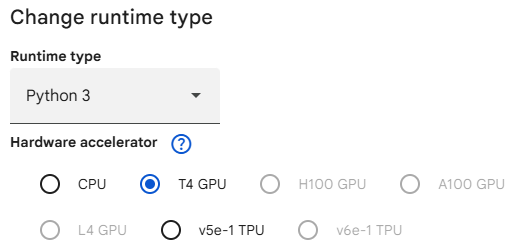

Normal runtime will takes much longer


## Setup

In [1]:
# ============================================================
# GPU & PARALLEL PROCESSING SETUP
# ============================================================
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed precision (float16) enabled")
    tf.config.optimizer.set_jit(True)
    print("✅ XLA JIT compilation enabled")
else:
    print("⚠️ No GPU — running on CPU (still works, just slower)")
    print("   Colab: Runtime > Change runtime type > T4 GPU")

num_cores = os.cpu_count()
tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)
print(f"✅ CPU parallelism: {num_cores} threads")
print(f"TensorFlow: {tf.__version__}")

✅ GPU detected: /physical_device:GPU:0
✅ Mixed precision (float16) enabled
✅ XLA JIT compilation enabled
✅ CPU parallelism: 2 threads
TensorFlow: 2.19.0


In [2]:
# ============================================================
# IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, string, re, warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

True

In [3]:
# ============================================================
# ⚡ CONFIGURATION — Adjust these for speed vs accuracy
# ============================================================
MAX_LEN = 500         # max sequence length (tokens)
VOCAB_SIZE = 5000     # vocabulary size
EMBED_DIM = 32        # embedding dimensions (smaller = faster)
BATCH_SIZE = 128      # batch size (larger = faster on GPU)
EPOCHS = 5            # max epochs
PATIENCE = 3          # early stopping patience

print(f"Config: MAX_LEN={MAX_LEN}, VOCAB={VOCAB_SIZE}, EMBED={EMBED_DIM}")
print(f"        BATCH={BATCH_SIZE}, EPOCHS={EPOCHS}, PATIENCE={PATIENCE}")

Config: MAX_LEN=500, VOCAB=5000, EMBED=32
        BATCH=128, EPOCHS=5, PATIENCE=3


In [4]:
# ============================================================
# DATA PATH — Works on both Colab and local
# ============================================================
import os, subprocess

# GitHub repo URL for raw data files
REPO = "https://raw.githubusercontent.com/79AceVo/Text-analytics/main/Data"

def get_data(filename, sep=','):
    """Load CSV from local Data/ folder or download from GitHub."""
    local_paths = [
        f"Data/{filename}",             # local: Data/ subfolder
        filename,                        # local: same directory
        f"/content/Data/{filename}",     # Colab: mounted drive
        f"/content/{filename}",          # Colab: uploaded file
    ]

    # Try local paths first
    for path in local_paths:
        if os.path.exists(path):
            print(f"✅ Found locally: {path}")
            return pd.read_csv(path, sep=sep, low_memory=False)

    # Download from GitHub
    url = f"{REPO}/{filename}"
    print(f"⬇️  Downloading from GitHub: {filename}...")
    try:
        df = pd.read_csv(url, sep=sep, low_memory=False)
        print(f"✅ Downloaded ({len(df)} rows)")
        return df
    except Exception as e:
        print(f"❌ Download failed: {e}")
        print(f"   Please place {filename} in a Data/ folder or upload it.")
        raise

print("✅ get_data() ready — checks local paths first, downloads from GitHub if needed")

✅ get_data() ready — checks local paths first, downloads from GitHub if needed


In [5]:
# ============================================================
# TEXT CLEANING
# ============================================================
stop_words = set(stopwords.words('english'))

def clean(text):
    """Remove HTML, punctuation, digits, stopwords."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', ' ', text)           # remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)    # keep letters only
    text = text.lower().split()
    text = [w for w in text if w not in stop_words and len(w) > 2]
    return " ".join(text)

print("✅ clean() function ready")

✅ clean() function ready


In [6]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    """Create optimized tf.data pipeline with cache + prefetch."""
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(len(X), seed=42)
    ds = ds.batch(batch_size).cache().prefetch(AUTOTUNE)
    return ds

def plot_history(history, title="Model"):
    """Plot training & validation loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['loss'], label='Train', color='steelblue')
    ax1.plot(history.history['val_loss'], label='Val', color='coral')
    ax1.set_title(f'{title} — Loss'); ax1.set_xlabel('Epoch')
    ax1.legend(); ax1.grid(True, alpha=0.3)
    acc_key = [k for k in history.history if 'accuracy' in k and 'val' not in k][0]
    val_key = 'val_' + acc_key
    ax2.plot(history.history[acc_key], label='Train', color='steelblue')
    ax2.plot(history.history[val_key], label='Val', color='coral')
    ax2.set_title(f'{title} — Accuracy'); ax2.set_xlabel('Epoch')
    ax2.legend(); ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def evaluate_binary(model, X_test, y_test, title="Model"):
    """Evaluate binary classifier with report + confusion matrix."""
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
    print(f"\n{'='*50}\n  {title}\n{'='*50}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(4, 3))
    disp.plot(ax=ax, cmap='Blues'); ax.set_title(title)
    plt.tight_layout(); plt.show()

def evaluate_multiclass(model, X_test, y_test, class_names, title="Model"):
    """Evaluate multi-class classifier."""
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    print(f"\n{'='*50}\n  {title}\n{'='*50}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues')
    plt.xticks(rotation=45, ha='right'); ax.set_title(title)
    plt.tight_layout(); plt.show()

def evaluate_multilabel(model, X_test, y_test, label_names, title="Model"):
    """Evaluate multi-label classifier."""
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
    print(f"\n{'='*50}\n  {title} — Multi-Label\n{'='*50}")
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))
    print("Per-label accuracy:")
    for i, name in enumerate(label_names):
        print(f"  {name}: {accuracy_score(y_test[:, i], y_pred[:, i]):.3f}")

print("✅ Helpers ready (make_dataset, plot_history, evaluate functions)")

✅ Helpers ready (make_dataset, plot_history, evaluate functions)


---\n## Part 1: Binary — Email Spam\n### LSTM vs Bi-LSTM vs Stacked LSTM

In [7]:
# ============================================================
# LOAD DATA — Email Spam Classification (Binary)
# ============================================================
email_df = get_data('email_classification.csv')
print(f"Shape: {email_df.shape}")
print(f"\nClass distribution:")
print(email_df['label'].value_counts())

# Clean text
email_df['clean'] = email_df['email'].apply(clean)

# Encode: ham=0, spam=1
email_df['target'] = (email_df['label'] == 'spam').astype(int)
print(f"\nEncoded: ham=0 ({(email_df['target']==0).sum()}), spam=1 ({(email_df['target']==1).sum()})")
email_df.head(3)

⬇️  Downloading from GitHub: email_classification.csv...
✅ Downloaded (179 rows)
Shape: (179, 2)

Class distribution:
label
ham     100
spam     79
Name: count, dtype: int64

Encoded: ham=0 (100), spam=1 (79)


,email,label,clean,target
0,Upgrade to our premium plan for exclusive acce...,ham,upgrade premium plan exclusive access premium ...,0
1,Happy holidays from our team! Wishing you joy ...,ham,happy holidays team wishing joy prosperity season,0
2,We're hiring! Check out our career opportuniti...,ham,hiring check career opportunities join dynamic...,0


In [8]:
# ============================================================
# TOKENIZE & PAD — Binary
# ============================================================
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(email_df['clean'])

X = pad_sequences(tokenizer.texts_to_sequences(email_df['clean']),
                  maxlen=MAX_LEN, padding='post', truncating='post')
y = email_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Train balance: {dict(zip(*np.unique(y_train, return_counts=True)))}")

# tf.data pipelines
train_ds = make_dataset(X_train, y_train)
test_ds = make_dataset(X_test, y_test, shuffle=False)
print(f"✅ Pipelines: {len(train_ds)} train batches, {len(test_ds)} test batches")

Train: (134, 500) | Test: (45, 500)
Train balance: {np.int64(0): np.int64(75), np.int64(1): np.int64(59)}
✅ Pipelines: 2 train batches, 1 test batches



Training LSTM(32)...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 834ms/step - accuracy: 0.5734 - loss: 0.6913 - val_accuracy: 0.5556 - val_loss: 0.6916
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5936 - loss: 0.6905 - val_accuracy: 0.5556 - val_loss: 0.6929
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5758 - loss: 0.6914 - val_accuracy: 0.4444 - val_loss: 0.6944
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4038 - loss: 0.6963 - val_accuracy: 0.4444 - val_loss: 0.6962
  → Acc=0.5556 | Params=168,353 | 5.7s


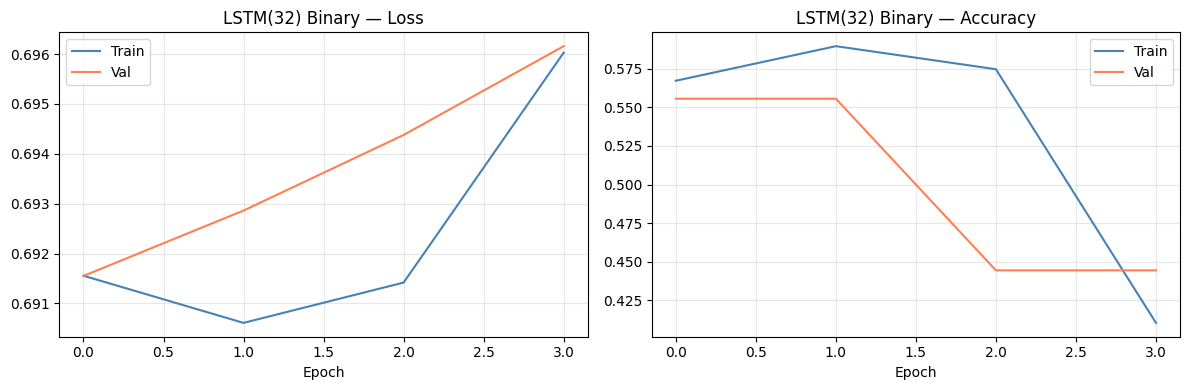


  LSTM(32) Binary
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        25
           1       0.00      0.00      0.00        20

    accuracy                           0.56        45
   macro avg       0.28      0.50      0.36        45
weighted avg       0.31      0.56      0.40        45



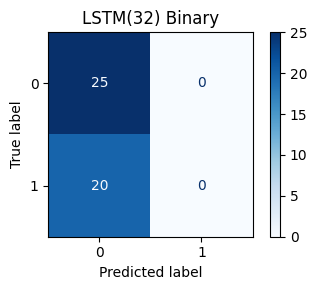

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 500, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,065 (1.93 MB)

 Trainable params: 168,353 (657.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 336,712 (1.28 MB)

In [14]:
# ============================================================
# LSTM vs Bi-LSTM vs Stacked — Binary
# ============================================================
results = {}

# --- LSTM Model ---
name_lstm = "LSTM(32)"
print(f"\nTraining {name_lstm}...")
model_lstm = keras.Sequential([
    layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN),
    layers.LSTM(32), layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', dtype='float32')])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                   restore_best_weights=True, verbose=0)
start = time.time()
h_lstm = model_lstm.fit(train_ds, epochs=EPOCHS, validation_data=test_ds,
                         callbacks=[es], verbose=1)
elapsed = time.time() - start
loss, acc = model_lstm.evaluate(X_test, y_test, verbose=0)
results[name_lstm] = {"Accuracy": round(acc, 4), "Params": model_lstm.count_params(),
                      "Epochs": len(h_lstm.history['loss']), "Time (s)": round(elapsed, 1)}
print(f"  → Acc={acc:.4f} | Params={model_lstm.count_params():,} | {elapsed:.1f}s")
plot_history(h_lstm, f"{name_lstm} Binary")
evaluate_binary(model_lstm, X_test, y_test, f"{name_lstm} Binary")
model_lstm.summary()




Training Bi-LSTM(32)...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 991ms/step - accuracy: 0.5583 - loss: 0.6920 - val_accuracy: 0.5556 - val_loss: 0.6886
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6011 - loss: 0.6874 - val_accuracy: 0.7556 - val_loss: 0.6878
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8131 - loss: 0.6861 - val_accuracy: 0.6667 - val_loss: 0.6870
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8257 - loss: 0.6833 - val_accuracy: 0.5111 - val_loss: 0.6860
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5478 - loss: 0.6838 - val_accuracy: 0.4444 - val_loss: 0.6848
  → Acc=0.4444 | Params=176,705 | 11.1s


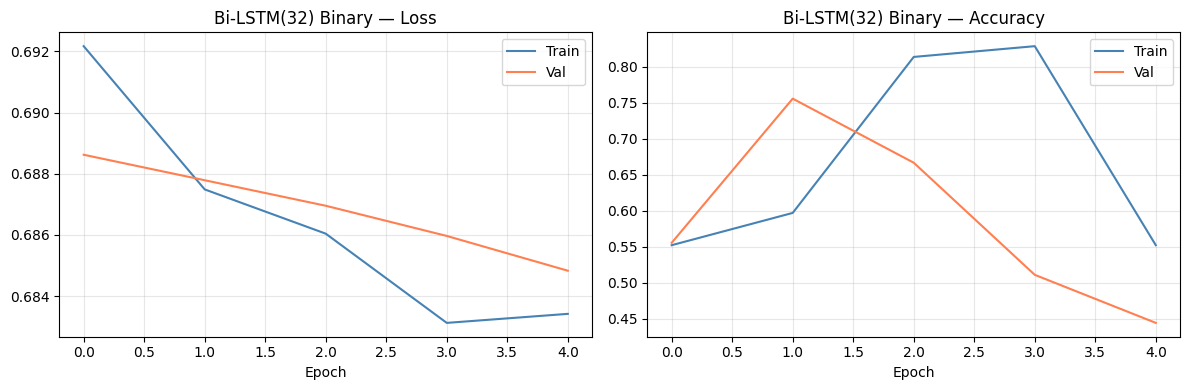


  Bi-LSTM(32) Binary
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45



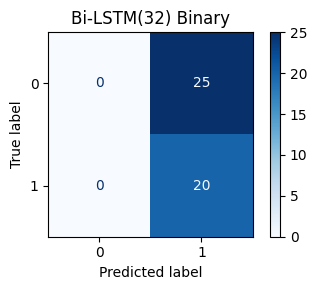

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 500, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 530,121 (2.02 MB)

 Trainable params: 176,705 (690.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 353,416 (1.35 MB)

In [15]:
# --- Bi-LSTM Model ---
name_bilstm = "Bi-LSTM(32)"
print(f"\nTraining {name_bilstm}...")
model_bilstm = keras.Sequential([
    layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(32)), layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', dtype='float32')])
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                   restore_best_weights=True, verbose=0)
start = time.time()
h_bilstm = model_bilstm.fit(train_ds, epochs=EPOCHS, validation_data=test_ds,
                            callbacks=[es], verbose=1)
elapsed = time.time() - start
loss, acc = model_bilstm.evaluate(X_test, y_test, verbose=0)
results[name_bilstm] = {"Accuracy": round(acc, 4), "Params": model_bilstm.count_params(),
                        "Epochs": len(h_bilstm.history['loss']), "Time (s)": round(elapsed, 1)}
print(f"  → Acc={acc:.4f} | Params={model_bilstm.count_params():,} | {elapsed:.1f}s")
plot_history(h_bilstm, f"{name_bilstm} Binary")
evaluate_binary(model_bilstm, X_test, y_test, f"{name_bilstm} Binary")
model_bilstm.summary()




Training Stacked LSTM...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4673 - loss: 0.6939 - val_accuracy: 0.5556 - val_loss: 0.6930
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5606 - loss: 0.6922 - val_accuracy: 0.4444 - val_loss: 0.6943
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4872 - loss: 0.6931 - val_accuracy: 0.4444 - val_loss: 0.6959
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4493 - loss: 0.6965 - val_accuracy: 0.4444 - val_loss: 0.6979
  → Acc=0.5556 | Params=171,473 | 12.1s


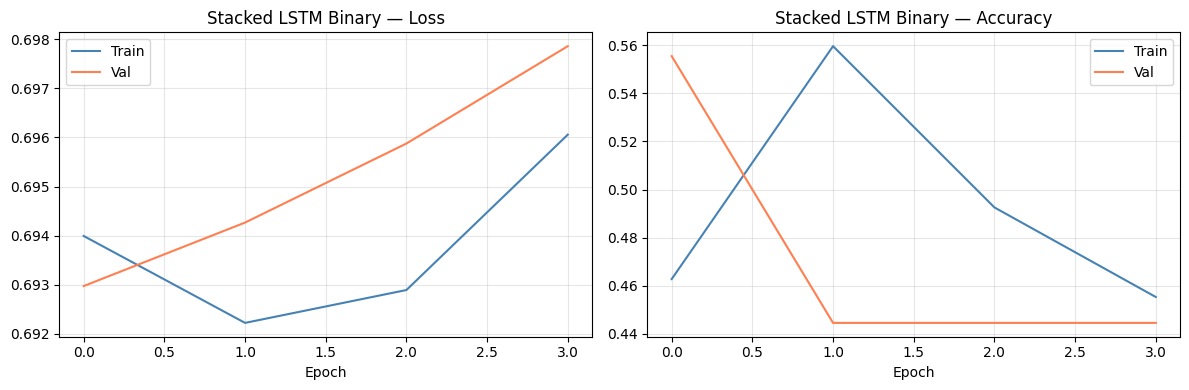


  Stacked LSTM Binary
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        25
           1       0.00      0.00      0.00        20

    accuracy                           0.56        45
   macro avg       0.28      0.50      0.36        45
weighted avg       0.31      0.56      0.40        45



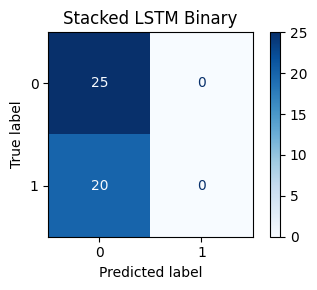

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 500, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 500, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,425 (1.96 MB)

 Trainable params: 171,473 (669.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 342,952 (1.31 MB)

In [16]:
# --- Stacked LSTM Model ---
name_stacked_lstm = "Stacked LSTM"
print(f"\nTraining {name_stacked_lstm}...")
model_stacked_lstm = keras.Sequential([
    layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN),
    layers.LSTM(32, return_sequences=True), layers.Dropout(0.2),
    layers.LSTM(16), layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', dtype='float32')])
model_stacked_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                   restore_best_weights=True, verbose=0)
start = time.time()
h_stacked_lstm = model_stacked_lstm.fit(train_ds, epochs=EPOCHS, validation_data=test_ds,
                                      callbacks=[es], verbose=1)
elapsed = time.time() - start
loss, acc = model_stacked_lstm.evaluate(X_test, y_test, verbose=0)
results[name_stacked_lstm] = {"Accuracy": round(acc, 4), "Params": model_stacked_lstm.count_params(),
                              "Epochs": len(h_stacked_lstm.history['loss']), "Time (s)": round(elapsed, 1)}
print(f"  → Acc={acc:.4f} | Params={model_stacked_lstm.count_params():,} | {elapsed:.1f}s")
plot_history(h_stacked_lstm, f"{name_stacked_lstm} Binary")
evaluate_binary(model_stacked_lstm, X_test, y_test, f"{name_stacked_lstm} Binary")
model_stacked_lstm.summary()




In [17]:
print(f"\n{'='*60}")
print(pd.DataFrame(results).T.to_string())


              Accuracy    Params  Epochs  Time (s)
LSTM(32)        0.5556  168353.0     4.0       5.7
Bi-LSTM(32)     0.4444  176705.0     5.0      11.1
Stacked LSTM    0.5556  171473.0     4.0      12.1


### Hyperparameter Experiment — LSTM

In [10]:
# ============================================================
# HYPERPARAMETER EXPERIMENTS — LSTM Binary
# ============================================================
configs = {
    "LSTM(16)":             {"units": 16, "dropout": 0.2, "bi": False},
    "LSTM(32) baseline":    {"units": 32, "dropout": 0.3, "bi": False},
    "LSTM(32) dropout=0.5": {"units": 32, "dropout": 0.5, "bi": False},
    "Bi-LSTM(16)":          {"units": 16, "dropout": 0.3, "bi": True},
    "Bi-LSTM(32)":          {"units": 32, "dropout": 0.3, "bi": True},
}

results = {}
for name, cfg in configs.items():
    rnn = layers.Bidirectional(layers.LSTM(cfg["units"])) if cfg["bi"] else layers.LSTM(cfg["units"])
    model = keras.Sequential([
        layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN),
        rnn, layers.Dropout(cfg["dropout"]),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                       restore_best_weights=True, verbose=0)
    start = time.time()
    h = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds,
                  callbacks=[es], verbose=0)
    elapsed = time.time() - start
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    results[name] = {"Accuracy": round(acc, 4), "Params": model.count_params(),
                     "Time (s)": round(elapsed, 1)}
    print(f"  {name}: Acc={acc:.4f} | {elapsed:.1f}s")

print(f"\n{pd.DataFrame(results).T.to_string()}")

  LSTM(16): Acc=0.5556 | 6.2s
  LSTM(32) baseline: Acc=0.5556 | 5.7s
  LSTM(32) dropout=0.5: Acc=0.5556 | 13.0s
  Bi-LSTM(16): Acc=0.4667 | 7.9s
  Bi-LSTM(32): Acc=0.5778 | 9.8s

                      Accuracy    Params  Time (s)
LSTM(16)                0.5556  163153.0       6.2
LSTM(32) baseline       0.5556  168353.0       5.7
LSTM(32) dropout=0.5    0.5556  168353.0      13.0
Bi-LSTM(16)             0.4667  166305.0       7.9
Bi-LSTM(32)             0.5778  176705.0       9.8


---\n## Part 2: Multi-class — BBC News (5 categories)

In [11]:
# ============================================================
# LOAD DATA — BBC News (Multi-class: 5 categories)
# ============================================================
bbc_df = get_data('bbc-news-data.csv', sep='\t')
print(f"Shape: {bbc_df.shape}")
print(f"\nCategory distribution:")
print(bbc_df['category'].value_counts())

# Clean text (title + content combined)
bbc_df['clean'] = (bbc_df['title'] + ' ' + bbc_df['content']).apply(clean)

# Encode labels
le = LabelEncoder()
bbc_df['target'] = le.fit_transform(bbc_df['category'])
class_names = list(le.classes_)
num_classes = len(class_names)
print(f"\nClasses: {dict(zip(class_names, range(num_classes)))}")

⬇️  Downloading from GitHub: bbc-news-data.csv...
✅ Downloaded (2225 rows)
Shape: (2225, 4)

Category distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Classes: {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [12]:
# ============================================================
# TOKENIZE & PAD — Multi-class
# ============================================================
tokenizer_mc = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_mc.fit_on_texts(bbc_df['clean'])

X_mc = pad_sequences(tokenizer_mc.texts_to_sequences(bbc_df['clean']),
                     maxlen=MAX_LEN, padding='post', truncating='post')
y_mc = bbc_df['target'].values

X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=0.25, random_state=42, stratify=y_mc)
print(f"Train: {X_train_mc.shape} | Test: {X_test_mc.shape}")

train_mc_ds = make_dataset(X_train_mc, y_train_mc)
test_mc_ds = make_dataset(X_test_mc, y_test_mc, shuffle=False)
print(f"✅ Multi-class pipelines ready")

Train: (1668, 500) | Test: (557, 500)
✅ Multi-class pipelines ready


Model: "BiLSTM_MultiClass"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.2244 - loss: 1.6051 - val_accuracy: 0.2370 - val_loss: 1.5965
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.3484 - loss: 1.5842 - val_accuracy: 0.4237 - val_loss: 1.5687
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4627 - loss: 1.5254 - val_accuracy: 0.4776 - val_loss: 1.3116
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5385 - loss: 1.2364 - val_accuracy: 0.5943 - val_loss: 1.0542
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6640 - loss: 0.9441 - val_accuracy: 0.6212 - val_loss: 0.8116
Restoring model weights from the end of the best epoch: 5.

⏱️ Training time: 11.3 seconds


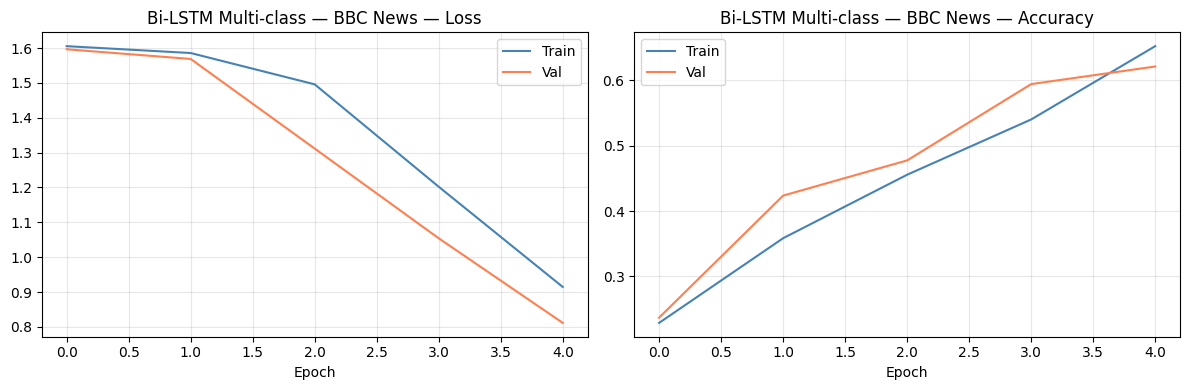


  Bi-LSTM Multi-class
               precision    recall  f1-score   support

     business       0.58      0.90      0.70       128
entertainment       0.25      0.04      0.07        97
     politics       0.86      0.06      0.11       104
        sport       0.97      0.95      0.96       128
         tech       0.48      1.00      0.65       100

     accuracy                           0.62       557
    macro avg       0.63      0.59      0.50       557
 weighted avg       0.64      0.62      0.53       557



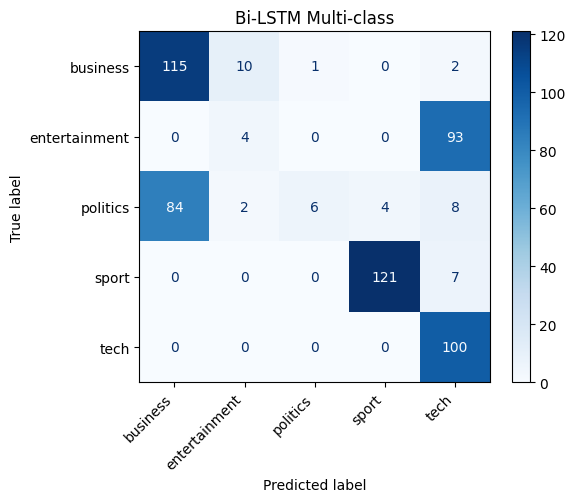

In [24]:
# Bi-LSTM — Multi-class
model = keras.Sequential([
    layers.Embedding(VOCAB_SIZE + 1, EMBED_DIM, input_length=MAX_LEN), # Add 1 to VOCAB_SIZE to account for OOV token
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes, activation='softmax', dtype='float32')
], name="BiLSTM_MultiClass")

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                   restore_best_weights=True, verbose=1)
train_start = time.time()
history = model.fit(train_mc_ds, epochs=EPOCHS,
                    validation_data=test_mc_ds, callbacks=[es], verbose=1)
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")

plot_history(history, "Bi-LSTM Multi-class — BBC News")
evaluate_multiclass(model, X_test_mc, y_test_mc, class_names, 'Bi-LSTM Multi-class')

---\n## Part 3: Multi-label — Toxic Comments (6 labels)

In [21]:
# ============================================================
# LOAD DATA — Toxic Comments (Multi-label: 6 labels)
# ============================================================
toxic_df = get_data('toxic_comments_1k.csv')

# Keep rows with actual text
toxic_df = toxic_df[toxic_df['comment_text'].notna()].copy()
print(f"Shape (with text): {toxic_df.shape}")

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for col in label_cols:
    toxic_df[col] = toxic_df[col].fillna(0).astype(int)

print(f"\nLabel distribution:")
for col in label_cols:
    print(f"  {col}: {toxic_df[col].sum()} positive ({toxic_df[col].mean()*100:.1f}%)")
print(f"Avg labels per comment: {toxic_df[label_cols].sum(axis=1).mean():.2f}")

# Clean text
toxic_df['clean'] = toxic_df['comment_text'].apply(clean)

⬇️  Downloading from GitHub: toxic_comments_1k.csv...
✅ Downloaded (159571 rows)
Shape (with text): (9999, 8)

Label distribution:
  toxic: 971 positive (9.7%)
  severe_toxic: 101 positive (1.0%)
  obscene: 527 positive (5.3%)
  threat: 33 positive (0.3%)
  insult: 494 positive (4.9%)
  identity_hate: 84 positive (0.8%)
Avg labels per comment: 0.22


In [22]:
# ============================================================
# TOKENIZE & PAD — Multi-label
# ============================================================
tokenizer_ml = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_ml.fit_on_texts(toxic_df['clean'])

X_ml = pad_sequences(tokenizer_ml.texts_to_sequences(toxic_df['clean']),
                     maxlen=MAX_LEN, padding='post', truncating='post')
y_ml = toxic_df[label_cols].values.astype(np.float32)
num_labels = len(label_cols)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.25, random_state=42)
print(f"Train: {X_train_ml.shape} | Labels: {y_train_ml.shape}")

train_ml_ds = make_dataset(X_train_ml, y_train_ml)
test_ml_ds = make_dataset(X_test_ml, y_test_ml, shuffle=False)
print(f"✅ Multi-label pipelines ready")

Train: (7499, 500) | Labels: (7499, 6)
✅ Multi-label pipelines ready


Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - binary_accuracy: 0.9250 - loss: 0.4444 - val_binary_accuracy: 0.9652 - val_loss: 0.1474
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - binary_accuracy: 0.9617 - loss: 0.1591 - val_binary_accuracy: 0.9652 - val_loss: 0.1341
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - binary_accuracy: 0.9617 - loss: 0.1499 - val_binary_accuracy: 0.9652 - val_loss: 0.1313
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - binary_accuracy: 0.9618 - loss: 0.1450 - val_binary_accuracy: 0.9653 - val_loss: 0.1237
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - binary_accuracy: 0.9622 - loss: 0.1267 - val_binary_accuracy: 0.9685 - val_loss: 0.0907
Restoring model weights from the end of the best epoch: 5.

⏱️ Training time: 21.1 seconds


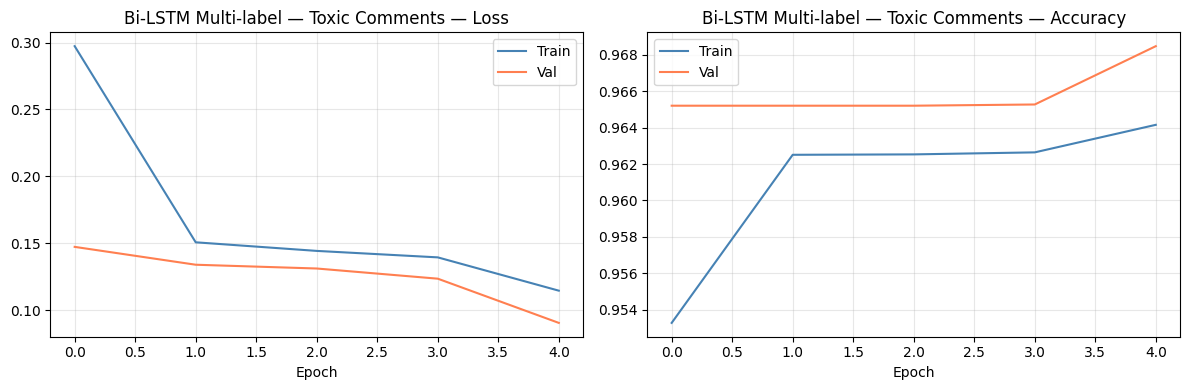


  Bi-LSTM Multi-label — Multi-Label
               precision    recall  f1-score   support

        toxic       0.98      0.22      0.36       235
 severe_toxic       1.00      0.04      0.07        28
      obscene       0.50      0.01      0.02       121
       threat       0.00      0.00      0.00         8
       insult       0.50      0.01      0.02       114
identity_hate       0.00      0.00      0.00        16

    micro avg       0.92      0.10      0.19       522
    macro avg       0.50      0.04      0.08       522
 weighted avg       0.72      0.10      0.17       522
  samples avg       0.02      0.01      0.01       522

Per-label accuracy:
  toxic: 0.926
  severe_toxic: 0.989
  obscene: 0.952
  threat: 0.996
  insult: 0.954
  identity_hate: 0.994


Model: "BiLSTM_MultiLabel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 500, 32)        │       160,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,448 (2.03 MB)

 Trainable params: 177,814 (694.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 355,634 (1.36 MB)

In [25]:
# Bi-LSTM — Multi-label
model = keras.Sequential([
    layers.Embedding(VOCAB_SIZE + 1, EMBED_DIM, input_length=MAX_LEN), # Corrected: Add 1 to VOCAB_SIZE for OOV token
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_labels, activation='sigmoid', dtype='float32')
], name="BiLSTM_MultiLabel")

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                   restore_best_weights=True, verbose=1)
train_start = time.time()
history = model.fit(train_ml_ds, epochs=EPOCHS,
                    validation_data=test_ml_ds, callbacks=[es], verbose=1)
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")

plot_history(history, "Bi-LSTM Multi-label — Toxic Comments")
evaluate_multilabel(model, X_test_ml, y_test_ml, label_cols, 'Bi-LSTM Multi-label')
model.summary()

---
## Summary
- `return_sequences=True` → intermediate LSTM (feeds next LSTM)
- `return_sequences=False` → final LSTM (feeds Dense)
- Bi-LSTM has ~2× parameters but captures context from both directions
